# **Colab 환경 설정**

**1. 필요 라이브러리 설치**

In [ ]:
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers
!pip install torch
!pip install numpy==1.23.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 101.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albucore 0.0.16 requires numpy>=1.24, but you have numpy 1.23.1 which is incompatible.
albumentations 1.4.15 requires numpy>=1.24.4, but you have numpy 1.23.1 which is incompatible.
bigframes 1.17.0 requires numpy>=1.24.0, but you have numpy 1.23.1 which is incompatible.
chex 0.1.86 requires numpy>=1.24.1, but you have numpy 1.23.1 which is incompatible.
pandas-stubs 2.1.4.231227 requires numpy>=1.26.0; python_version < "3.13", but you have numpy 1.23.1 which is incompatible.
tensorflow 2.17.0 requires numpy<2.0.0,>=1.23.5; python_version <= "3.11", but you have numpy 1.23.1 which is inc

**2. SKT KoBERT 깃허브에서 kobert_tokenizer 설치**

In [ ]:
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-31mcpd3z/kobert-tokenizer_79ae7c52f2034aab81ed9d0ca0bd402c
  Running command git clone --filter=blob:none --quiet https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-31mcpd3z/kobert-tokenizer_79ae7c52f2034aab81ed9d0ca0bd402c
  Resolved https://github.com/SKTBrain/KoBERT.git to commit 47a69af87928fc24e20f571fe10c3cc9dd9af9a3
  Preparing metadata (setup.py) ... done
  Created wheel for kobert_tokenizer: filename=kobert_tokenizer-0.1-py3-none-any.whl size=4632 sha256=5d802e90713f65452e9964cbb8941d3fa38fd7746b03dcc7dd6be0c4c0a66c5f
  Stored in directory: /tmp/pip-ephem-wheel-cache-hz73d48o/wheels/e9/1a/3f/a864970e8a169c176befa3c4a1e07aa612f69195907a4045fe
Successfully built kobert_tokenizer


**3. 라이브러리 import**

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

In [ ]:
from kobert_tokenizer import KoBERTTokenizer
from transformers import BertModel

from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup
device = torch.device("cuda:0")
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/371k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/535 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/369M [00:00<?, ?B/s]

**4. 구글 드라이브 마운트**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **데이터 전처리**

**1. 데이터 7개의 감정으로 분류**

In [ ]:
import pandas as pd
# [AI Hub] 감정 분류를 위한 대화 음성 데이터셋
chatbot_data  = pd.read_excel("./sample_data/한국어_단발성_대화_데이터셋.xlsx")

chatbot_data.sample(n=10)
# 7개의 감정 class → 숫자
chatbot_data.loc[(chatbot_data['Emotion'] == "공포"), 'Emotion'] = 0  #공포 => 0
chatbot_data.loc[(chatbot_data['Emotion'] == "놀람"), 'Emotion'] = 1  #놀람 => 1
chatbot_data.loc[(chatbot_data['Emotion'] == "분노"), 'Emotion'] = 2  #분노 => 2
chatbot_data.loc[(chatbot_data['Emotion'] == "슬픔"), 'Emotion'] = 3  #슬픔 => 3
chatbot_data.loc[(chatbot_data['Emotion'] == "중립"), 'Emotion'] = 4  #중립 => 4
chatbot_data.loc[(chatbot_data['Emotion'] == "행복"), 'Emotion'] = 5  #행복 => 5
chatbot_data.loc[(chatbot_data['Emotion'] == "혐오"), 'Emotion'] = 6  #혐오 => 6

data_list = []
for q, label in zip(chatbot_data['Sentence'], chatbot_data['Emotion'])  :
    data = []
    data.append(q)
    data.append(str(label))

    data_list.append(data)

print(data)
print(data_list[:10])

['와이프도 그렇고 댓글 다 볼텐데 이휘재 좀 하차 하라고 전해주세요', '6']
[['언니 동생으로 부르는게 맞는 일인가요..??', '0'], ['그냥 내 느낌일뿐겠지?', '0'], ['아직너무초기라서 그런거죠?', '0'], ['유치원버스 사고 낫다던데', '0'], ['근데 원래이런거맞나요', '0'], [' 남자친구가 떠날까봐요', '0'], ['이거 했는데 허리가 아플수도 있나요? ;;', '0'], ['내가불안해서꾸는걸까..', '0'], [' 일주일도 안 남았당...ㅠㅠ', '0'], ['약은 최대한 안먹으려고 하는데좋은 음시있나요?0', '0']]


**2. 데이터셋 분류**

데이터셋을 sklearn을 통해 train&test로 나눈다

In [ ]:
#train & test 데이터로 나누기
from sklearn.model_selection import train_test_split
dataset_train, dataset_test = train_test_split(data_list, test_size = 0.2, shuffle = True, random_state = 32)

**3. 데이터셋 토큰화**

In [ ]:
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower = False)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, vocab, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, vocab=vocab, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

**4. 파라미터 세팅**

In [ ]:
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

**5. Data tokenization, int encoding, padding**

In [ ]:
# BERTDataset : 각 데이터가 BERT 모델의 입력으로 들어갈 수 있도록 tokenization, int encoding, padding하는 함수
tok = tokenizer.tokenize

data_train = BERTDataset(dataset_train, 0, 1, tok, vocab, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, vocab, max_len, True, False)

In [ ]:
# torch 형식의 dataset을 만들어 입력 데이터셋의 전처리 마무리
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size = batch_size, num_workers = 5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size = batch_size, num_workers = 5)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# **Kobert 모델 구현**

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes = 7,   # 감정 클래스 수로 조정
                 dr_rate = None,
                 params = None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p = dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)

        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device),return_dict = False)
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

**1. optimizer와 schedule 설정**

In [ ]:
# BERT  모델 불러오기
model = BERTClassifier(bertmodel,  dr_rate = 0.5).to(device)

# optimizer와 schedule 설정
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]


optimizer = AdamW(optimizer_grouped_parameters, lr = learning_rate)
loss_fn = nn.CrossEntropyLoss() # 다중분류를 위한 loss function

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps = warmup_step, num_training_steps = t_total)

# calc_accuracy : 정확도 측정을 위한 함수
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

train_dataloader

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


**2. GPU 사용 가능 여부 확인 및 GPU 설정**

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = torch.device("cuda:0")

# **학습**

In [ ]:
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))

    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

<ipython-input-17-c43874aa7363>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/483 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 2.011289119720459 train acc 0.15625
epoch 1 batch id 201 loss 1.4664955139160156 train acc 0.2835820895522388
epoch 1 batch id 401 loss 1.22026526927948 train acc 0.38817019950124687
epoch 1 train acc 0.41030332221455407


<ipython-input-17-c43874aa7363>:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):


  0%|          | 0/121 [00:00<?, ?it/s]

epoch 1 test acc 0.5223166984530621


  0%|          | 0/483 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 1.186051368713379 train acc 0.625
epoch 2 batch id 201 loss 1.117651343345642 train acc 0.540889303482587
epoch 2 batch id 401 loss 0.88216233253479 train acc 0.5732933291770573
epoch 2 train acc 0.5798766869871943


  0%|          | 0/121 [00:00<?, ?it/s]

epoch 2 test acc 0.5495635992795084


  0%|          | 0/483 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.9256256222724915 train acc 0.640625
epoch 3 batch id 201 loss 0.8052369952201843 train acc 0.6384483830845771
epoch 3 batch id 401 loss 0.840488076210022 train acc 0.6726543017456359
epoch 3 train acc 0.678673270838126


  0%|          | 0/121 [00:00<?, ?it/s]

epoch 3 test acc 0.5493053348166984


  0%|          | 0/483 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.7894892692565918 train acc 0.734375
epoch 4 batch id 201 loss 0.6095080971717834 train acc 0.7352300995024875
epoch 4 batch id 401 loss 0.5949944853782654 train acc 0.7597802369077307
epoch 4 train acc 0.763709167241776


  0%|          | 0/121 [00:00<?, ?it/s]

epoch 4 test acc 0.5527455499046408


  0%|          | 0/483 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.6839560866355896 train acc 0.78125
epoch 5 batch id 201 loss 0.4496276378631592 train acc 0.798896144278607
epoch 5 batch id 401 loss 0.5535704493522644 train acc 0.8154223815461347
epoch 5 train acc 0.8177047389003911


  0%|          | 0/121 [00:00<?, ?it/s]

epoch 5 test acc 0.5558447234583598


* 코드실행결과

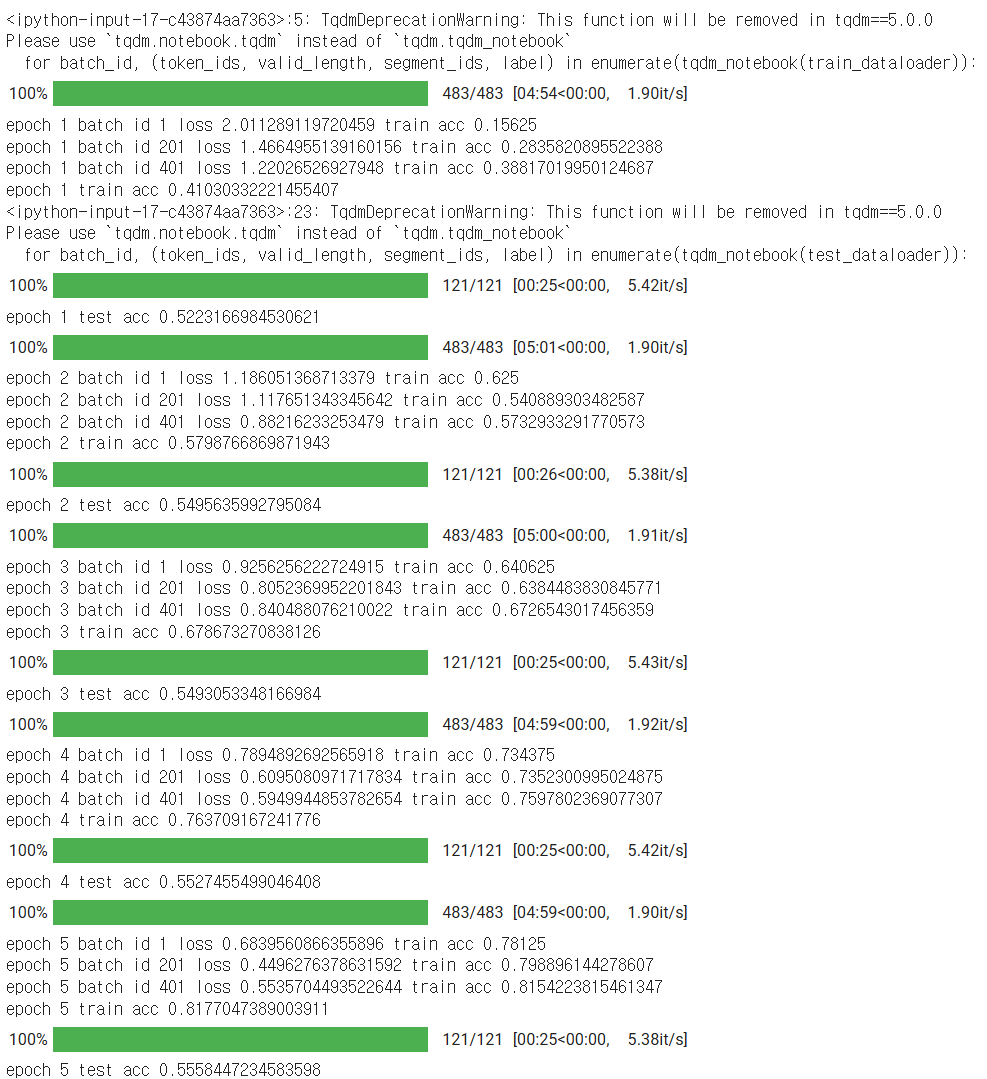

# **테스트**

In [ ]:
def predict(predict_sentence): # input = 감정분류하고자 하는 sentence

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tok, vocab, max_len, True, False) # 토큰화한 문장
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size = batch_size, num_workers = 5) # torch 형식 변환

    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length = valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)


        test_eval = []
        for i in out: # out = model(token_ids, valid_length, segment_ids)
            logits = i
            logits = logits.detach().cpu().numpy()

            if np.argmax(logits) == 0:
                test_eval.append("공포가")
            elif np.argmax(logits) == 1:
                test_eval.append("놀람이")
            elif np.argmax(logits) == 2:
                test_eval.append("분노가")
            elif np.argmax(logits) == 3:
                test_eval.append("슬픔이")
            elif np.argmax(logits) == 4:
                test_eval.append("중립이")
            elif np.argmax(logits) == 5:
                test_eval.append("행복이")
            elif np.argmax(logits) == 6:
                test_eval.append("혐오가")

        print(">> 입력하신 내용에서 " + test_eval[0] + " 느껴집니다.")

In [ ]:
# 질문에 0 입력 시 종료
end = 1
while end == 1 :
    sentence = input("하고싶은 말을 입력해주세요 : ")
    if sentence == "0" :
        break
    predict(sentence)
    print("\n")

하고싶은 말을 입력해주세요 : 안녕
>> 입력하신 내용에서 행복이 느껴집니다.


하고싶은 말을 입력해주세요 : 어서오세요
>> 입력하신 내용에서 행복이 느껴집니다.


하고싶은 말을 입력해주세요 : 아프다
>> 입력하신 내용에서 슬픔이 느껴집니다.


하고싶은 말을 입력해주세요 : 네가 밉다
>> 입력하신 내용에서 놀람이 느껴집니다.


하고싶은 말을 입력해주세요 : 하하하하
>> 입력하신 내용에서 행복이 느껴집니다.


하고싶은 말을 입력해주세요 : 어어엉
>> 입력하신 내용에서 놀람이 느껴집니다.


하고싶은 말을 입력해주세요 : 흑흑
>> 입력하신 내용에서 놀람이 느껴집니다.


하고싶은 말을 입력해주세요 : 오늘은 비가 추적추적 내립니다
>> 입력하신 내용에서 중립이 느껴집니다.


하고싶은 말을 입력해주세요 : 여전히 아름답워요
>> 입력하신 내용에서 행복이 느껴집니다.


하고싶은 말을 입력해주세요 : 못생겼네요
>> 입력하신 내용에서 혐오가 느껴집니다.


하고싶은 말을 입력해주세요 : 0


In [ ]:
#구글드라이브 연동
#from google.colab import drive
#drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/models_k2/')
os.getcwd()

path = '/content/drive/MyDrive/models_k2/'
torch.save(model, path + '7emotions_model.pt')  # 전체 모델 저장

torch.save(model.state_dict(), '7emotions_model_state_dict.pt')  # 모델 객체의 state_dict 저장

torch.save({
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict()
}, '7emotions_all.tar')  # 여러 가지 값 저장, 학습 중 진행 상황 저장을 위해 epoch, loss 값 등 일반 scalar값 저장 가능

In [ ]:
#구글드라이브 연동
#from google.colab import drive
#drive.mount('/content/drive')

#★★★현재경로가 model이 있는 폴더여야함★★★
import os
os.chdir('/content/drive/MyDrive/models_k2/')

model1 = torch.load('7emotions_model.pt')  # 전체 모델을 통째로 불러옴, 클래스 선언 필수
model1.load_state_dict(torch.load('7emotions_model_state_dict.pt'))  # state_dict를 불러 온 후, 모델에 저장

checkpoint = torch.load('7emotions_all.tar')   # dict 불러오기
model1.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])

#토큰화
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower = False)

def predict(predict_sentence):

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tok, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)

    model1.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model1(token_ids, valid_length, segment_ids)


        test_eval=[]
        for i in out:
            logits=i
            logits = logits.detach().cpu().numpy()

            if np.argmax(logits) == 0:
                test_eval.append("공포가")
            elif np.argmax(logits) == 1:
                test_eval.append("놀람이")
            elif np.argmax(logits) == 2:
                test_eval.append("분노가")
            elif np.argmax(logits) == 3:
                test_eval.append("슬픔이")
            elif np.argmax(logits) == 4:
                test_eval.append("중립이")
            elif np.argmax(logits) == 5:
                test_eval.append("행복이")
            elif np.argmax(logits) == 6:
                test_eval.append("혐오가")

            #test_eval.append(np.argmax(logits))

        print(">> 입력하신 내용에서 " + test_eval[0] + " 느껴집니다.")

predict_sentence = '영화에 나오는 귀신이 너무 무섭네요'

predict(predict_sentence)

#질문 무한반복하기! 0 입력시 종료
end = 1
while end == 1 :
    sentence = input("하고싶은 말을 입력해주세요 : ")
    if sentence == '0' :
        break
    predict(sentence)
    print("\n")